#**ANÁLISIS DE MOVIMIENTOS MIGRATORIOS CON SPARK**

Eres parte de un equipo de analistas de datos encargado de estudiar las tendencias de migración  humana en el siglo XXI utilizando Big Data.

Para ello, trabajarás con un conjunto de datos que  contiene información sobre migraciones entre distintos países, sus causas y el impacto  socioeconómico en las regiones de origen y destino.

Objetivos de la actividad:
1. Aplicar conceptos de Big Data utilizando Apache Spark y PySpark.
2. Explorar y transformar datos con RDDs y DataFrames.
3. Realizar consultas con Spark SQL.
4. Implementar modelos de aprendizaje automático con MLlib.


##**Importar librerías**

In [106]:
from google.colab import drive
drive.mount('/content/drive')

ruta_archivos = '/content/drive/MyDrive/bootcamp_ciencia_de_datos/evaluaciones/archivos_spark/'

#!pip install -q pyspark

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [107]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.stat import Correlation

import builtins

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

**1. Carga y exploración de datos (2 puntos)**
- Carga el dataset proporcionado en Spark.
- Convierte los datos en un RDD y un DataFrame.
- Explora los datos: muestra las primeras filas, el esquema y genera estadísticas descriptivas.

In [108]:
# crear una SparkSession
sesion_spark = SparkSession.builder.appName("AnalisisMigraciones").getOrCreate()

print(f'✅ SparkSession creada exitosamente')

✅ SparkSession creada exitosamente


In [109]:
sesion_spark

###**DataFrame**

In [110]:
ruta_dataset = ruta_archivos + 'migraciones.csv'

df = sesion_spark.read.csv(ruta_dataset, header=True, inferSchema=True)
print(f'✅ Spark dataframe "df" creado exitosamente')

num_filas = df.count()
num_columnas = len(df.columns)
print(f'Dimensión df = {(num_filas, num_columnas)}')

n = 5
print(f'\nVistazo a las primeras {n} filas de df:')
df.show(truncate=False)

print('\nEsquema de df:')
df.printSchema()

✅ Spark dataframe "df" creado exitosamente
Dimensión df = (5, 13)

Vistazo a las primeras 5 filas de df:
+---+---------+---------------+----+---------+----------+-----------+---------------------+----------------------+----------------------+-----------------------+----------------+-----------------+
|ID |Origen   |Destino        |Año |Razón    |PIB_Origen|PIB_Destino|Tasa_Desempleo_Origen|Tasa_Desempleo_Destino|Nivel_Educativo_Origen|Nivel_Educativo_Destino|Población_Origen|Población_Destino|
+---+---------+---------------+----+---------+----------+-----------+---------------------+----------------------+----------------------+-----------------------+----------------+-----------------+
|1  |México   |EEUU           |2015|Económica|8900      |62000      |5.2                  |3.8                   |8.5                   |12.3                   |125000000       |331000000        |
|2  |Siria    |Alemania       |2016|Conflicto|2500      |45000      |15.4                 |4.5             

In [111]:
# revisar los nulos

df_nulos = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])
sum_expression = " + ".join([f"`{c}`" for c in df_nulos.columns])
total_nulos = df_nulos.select(expr(sum_expression).alias("total_nulos")).collect()[0][0]

print(f'Total de valores nulos en df: {total_nulos}')
df_nulos.show(truncate=False)


Total de valores nulos en df: 0
+---+------+-------+---+-----+----------+-----------+---------------------+----------------------+----------------------+-----------------------+----------------+-----------------+
|ID |Origen|Destino|Año|Razón|PIB_Origen|PIB_Destino|Tasa_Desempleo_Origen|Tasa_Desempleo_Destino|Nivel_Educativo_Origen|Nivel_Educativo_Destino|Población_Origen|Población_Destino|
+---+------+-------+---+-----+----------+-----------+---------------------+----------------------+----------------------+-----------------------+----------------+-----------------+
|0  |0     |0      |0  |0    |0         |0          |0                    |0                     |0                     |0                      |0               |0                |
+---+------+-------+---+-----+----------+-----------+---------------------+----------------------+----------------------+-----------------------+----------------+-----------------+



In [112]:
# revisar los duplicados

df_duplicados = df.groupBy(df.columns).count().filter("count > 1")

if df_duplicados.count() > 0:
    print("Hay filas duplicadas:")
    df_duplicados.show(truncate=False)
else:
    print("No hay duplicados")

No hay duplicados


In [113]:
# estadísticas descriptivas

# seleccionar solo los valores que son números
col_num = [c[0] for c in df.dtypes if c[1] in ['int', 'bigint', 'double', 'float']]

col_num.remove('ID') # remover el ID

print('\nEstadísticas descriptivas para df:')
df.select(col_num).describe().show(truncate=False)


Estadísticas descriptivas para df:
+-------+------------------+------------------+------------------+---------------------+----------------------+----------------------+-----------------------+-------------------+-------------------+
|summary|Año               |PIB_Origen        |PIB_Destino       |Tasa_Desempleo_Origen|Tasa_Desempleo_Destino|Nivel_Educativo_Origen|Nivel_Educativo_Destino|Población_Origen   |Población_Destino  |
+-------+------------------+------------------+------------------+---------------------+----------------------+----------------------+-----------------------+-------------------+-------------------+
|count  |5                 |5                 |5                 |5                    |5                     |5                     |5                      |5                  |5                  |
|mean   |2017.0            |5920.0            |39800.0           |10.420000000000002   |6.68                  |8.66                  |12.84                  |3.192E8   

###**RDD**

In [114]:
# primera manera de cargar el rdd: leyendo el archivo sin pasar antes por un dataFrame

sc = sesion_spark.sparkContext
rdd = sc.textFile(ruta_dataset)
print(f'✅ "rdd" creado exitosamente')

header = rdd.first()
rdd = rdd.filter(lambda x: x != header) # eliminar header

campos = header.split(',')
num_campos = len(campos)
num_filas = rdd.count()

# preparar el rdd definitivo como tuplas y cachearlo

def parse_lineas(linea):
    id, orig, dest, ano, razon, pib_orig, pib_dest, td_orig, td_dest, ne_orig, ne_dest, pobl_orig, pobl_dest = linea.split(',')
    return int(id), orig, dest, int(ano), razon, int(pib_orig), int(pib_dest), float(td_orig), float(td_dest), float(ne_orig), float(ne_dest), int(pobl_orig), int(pobl_dest)

rdd = rdd.map(parse_lineas).cache()

print(f'Dimensión rdd = {(num_filas, num_campos)}')
print(f'\nVistazo a los registros del rdd (sin encabezado):')
for elemento in rdd.collect():
    print(elemento)

# variables registrar la posición de cada campo del rrd
id, orig, dest, ano, raz, pib_o, pib_d, td_o, td_d, ne_o, ne_d, pobl_o, pobl_d = range(num_campos)

✅ "rdd" creado exitosamente
Dimensión rdd = (5, 13)

Vistazo a los registros del rdd (sin encabezado):
(1, 'México', 'EEUU', 2015, 'Económica', 8900, 62000, 5.2, 3.8, 8.5, 12.3, 125000000, 331000000)
(2, 'Siria', 'Alemania', 2016, 'Conflicto', 2500, 45000, 15.4, 4.5, 6.2, 14.1, 18000000, 83000000)
(3, 'Venezuela', 'Colombia', 2017, 'Política', 6000, 15000, 14.8, 10.1, 9.3, 11.0, 28000000, 50000000)
(4, 'India', 'Emiratos Árabes', 2018, 'Laboral', 2200, 43000, 7.2, 1.8, 7.8, 13.0, 1380000000, 9800000)
(5, 'Argentina', 'España', 2019, 'Económica', 10000, 34000, 9.5, 13.2, 11.5, 13.8, 45000000, 47000000)


In [115]:
# segunda manera de cargar el rdd: conversión de spark df a RDD
# de todas maneras, seguiré trabajando con el rdd constrido por el primer método

rdd_1 = df.rdd
print(f'✅ "rdd_1" creado exitosamente')

# convertir objeto row a tupla
def row_a_tuple(row):
    return (row['ID'], row['Origen'], row['Destino'], row['Año'], row['Razón'],
            row['PIB_Origen'], row['PIB_Destino'], row['Tasa_Desempleo_Origen'],
            row['Tasa_Desempleo_Destino'], row['Nivel_Educativo_Origen'],
            row['Nivel_Educativo_Destino'], row['Población_Origen'], row['Población_Destino'])


rdd_1 = rdd_1.map(row_a_tuple).cache()

num_campos = len(rdd.first())
num_filas = rdd_1.count()

print(f'Dimensión rdd = {(num_filas, num_campos)}')
print(f'\nVistazo a los registros del rdd:')
for elemento in rdd_1.collect():
    print(elemento)

✅ "rdd_1" creado exitosamente
Dimensión rdd = (5, 13)

Vistazo a los registros del rdd:
(1, 'México', 'EEUU', 2015, 'Económica', 8900, 62000, 5.2, 3.8, 8.5, 12.3, 125000000, 331000000)
(2, 'Siria', 'Alemania', 2016, 'Conflicto', 2500, 45000, 15.4, 4.5, 6.2, 14.1, 18000000, 83000000)
(3, 'Venezuela', 'Colombia', 2017, 'Política', 6000, 15000, 14.8, 10.1, 9.3, 11.0, 28000000, 50000000)
(4, 'India', 'Emiratos Árabes', 2018, 'Laboral', 2200, 43000, 7.2, 1.8, 7.8, 13.0, 1380000000, 9800000)
(5, 'Argentina', 'España', 2019, 'Económica', 10000, 34000, 9.5, 13.2, 11.5, 13.8, 45000000, 47000000)


Los rdd no tienen un equivalente a printSchema() de los dataframes spark porque son "schema-less".

In [116]:
def rdd_estadisticas(rdd, index):
    '''Estadísticas descriptivas.'''

    rdd_valores = rdd.map(lambda x: x[index])

    count = rdd_valores.count()
    mean = rdd_valores.mean()
    stdev = rdd_valores.stdev()
    min_val = rdd_valores.min()
    max_val = rdd_valores.max()

    return count, mean, stdev, min_val, max_val

primer_registro = rdd.first()
campos_num_indices = [i for i, value in enumerate(primer_registro) if isinstance(value, (int, float))]
campos_num_indices.remove(id) # remover el ID

print("Estadísticas descriptivas para el RDD:")
for i in campos_num_indices:
    column_name = campos[i]
    count, mean, min_val, max_val, stdev = rdd_estadisticas(rdd, i)
    print(f"\nEstadísticas para '{column_name}':")
    print(f"  Count: {count}")
    print(f"  Mean: {mean}")
    print(f"  Standard Deviation: {stdev}")
    print(f"  Min: {min_val}")
    print(f"  Max: {max_val}")

Estadísticas descriptivas para el RDD:

Estadísticas para 'Año':
  Count: 5
  Mean: 2017.0
  Standard Deviation: 2019
  Min: 1.4142135623730951
  Max: 2015

Estadísticas para 'PIB_Origen':
  Count: 5
  Mean: 5920.0
  Standard Deviation: 10000
  Min: 3195.872337875842
  Max: 2200

Estadísticas para 'PIB_Destino':
  Count: 5
  Mean: 39800.0
  Standard Deviation: 62000
  Min: 15354.478174135387
  Max: 15000

Estadísticas para 'Tasa_Desempleo_Origen':
  Count: 5
  Mean: 10.42
  Standard Deviation: 15.4
  Min: 4.060738849027354
  Max: 5.2

Estadísticas para 'Tasa_Desempleo_Destino':
  Count: 5
  Mean: 6.6800000000000015
  Standard Deviation: 13.2
  Min: 4.267739448466834
  Max: 1.8

Estadísticas para 'Nivel_Educativo_Origen':
  Count: 5
  Mean: 8.66
  Standard Deviation: 11.5
  Min: 1.748828179095934
  Max: 6.2

Estadísticas para 'Nivel_Educativo_Destino':
  Count: 5
  Mean: 12.839999999999998
  Standard Deviation: 14.1
  Min: 1.114629983447422
  Max: 11.0

Estadísticas para 'Población_Orig

##**2. Procesamiento de datos con RDDs y DataFrames (3 puntos)**
- Aplica transformaciones sobre los RDDs (filter, map, flatMap).
- Aplica acciones sobre los RDDs (collect, take, count).
- Realiza operaciones con DataFrames: filtrado, agregaciones y ordenamiento.
- Escribe los resultados en formato Parquet.

###**Trasformaciones y acciones sobre RDD**

In [117]:
# países de origen y destino de los migrantes por razones económicas

filtro_razon_economica = (rdd.filter(lambda x: x[raz] == "Económica")
                             .map(lambda x: (x[orig], x[dest]))
)

print(f'Migraciones por razones económicas:')
for fila in filtro_razon_economica.collect():
    print(f'{fila[0]:>15} emigra a {fila[1]:>15}')

print(f'\nTotal de países desde donde se migra por razones económicas: {filtro_razon_economica.count()}')

Migraciones por razones económicas:
         México emigra a            EEUU
      Argentina emigra a          España

Total de países desde donde se migra por razones económicas: 2


In [118]:
# contar el número de países de origen de los migrantes recibidos en cada país de destino

cuenta_paises_origen_por_destino = (rdd.map(lambda x: (x[dest], 1))        # (dest, 1)
                                       .reduceByKey(lambda x, y: x + y)    # (dest, sum_1)
)
print(f'Cuenta de países de origen por país de destino:')
for fila in cuenta_paises_origen_por_destino.collect():
    print(f'{fila[0]:>15} recibe de {fila[1]} país(es)')

Cuenta de países de origen por país de destino:
       Alemania recibe de 1 país(es)
           EEUU recibe de 1 país(es)
       Colombia recibe de 1 país(es)
Emiratos Árabes recibe de 1 país(es)
         España recibe de 1 país(es)


In [119]:
# determinar las 2 tuplas de países origen/destino con mayor tasa PIB_Destino / PIB_Origen (usando flat)

razon_tasa_PIBs = (rdd.map(lambda x: ((x[orig], x[dest]), (x[pib_d] / x[pib_o])) )   # ( (orig, dest) , (pib_d/) )
                      .reduceByKey(lambda x, y: x if x > y else y)                   # ( (orig, dest) , max(pib_d/) )
                      .sortBy(lambda x: x[1], ascending=False)                       # ( (orig, dest) , max(pib_d/) ) ordenado desc
)

print(f'Tuplas de países origen/destino con mayor tasa PIB_Destino / PIB_Origen:')
for fila in razon_tasa_PIBs.take(2):
    print(f'{fila[0][0]:>15} emigra {fila[0][1]:>15} : {fila[1]:.2f}')

Tuplas de países origen/destino con mayor tasa PIB_Destino / PIB_Origen:
          India emigra Emiratos Árabes : 19.55
          Siria emigra        Alemania : 18.00


In [120]:
# determinar tuplas de países origen/destino con su respectiva razón Tasa_Desempleo_Origen / Tasa_Desempleo_Destino (usando map y flatmap)

map_razon_tasa_desempleo = (rdd.map(lambda x: ((x[orig], x[dest]), (x[td_o] / x[td_d])) )
)

flatmap_razon_tasa_desempleo = (rdd.flatMap(lambda x: ((x[orig], x[dest]), (x[td_o] / x[td_d])) )
)

print(f'USANDO MAP: Tuplas de países origen/destino y su razón Tasa_Desempleo_Origen / Tasa_Desempleo_Destino:')
for fila in map_razon_tasa_desempleo.collect():
    print(fila)
print(f'\nNúmero de filas = {map_razon_tasa_desempleo.count()}')

print('\n','='*100, '\n')

print(f'USANDO FLATMAP: Tuplas de países origen/destino y su razón Tasa_Desempleo_Origen / Tasa_Desempleo_Destino:')
for fila in flatmap_razon_tasa_desempleo.collect():
    print(fila)
print(f'\nNúmero de filas = {flatmap_razon_tasa_desempleo.count()}')

USANDO MAP: Tuplas de países origen/destino y su razón Tasa_Desempleo_Origen / Tasa_Desempleo_Destino:
(('México', 'EEUU'), 1.368421052631579)
(('Siria', 'Alemania'), 3.4222222222222225)
(('Venezuela', 'Colombia'), 1.4653465346534655)
(('India', 'Emiratos Árabes'), 4.0)
(('Argentina', 'España'), 0.7196969696969697)

Número de filas = 5


USANDO FLATMAP: Tuplas de países origen/destino y su razón Tasa_Desempleo_Origen / Tasa_Desempleo_Destino:
('México', 'EEUU')
1.368421052631579
('Siria', 'Alemania')
3.4222222222222225
('Venezuela', 'Colombia')
1.4653465346534655
('India', 'Emiratos Árabes')
4.0
('Argentina', 'España')
0.7196969696969697

Número de filas = 10


Se nota como flatMap "aplana" la lista generada con map, pasando de 5 filas (para map) a 10 filas (para flatMap).

###**Transformaciones sobre df**

In [121]:
# filter: Migraciones por razones económicas

filtro_razon_economica = df.filter(df['Razón'] == "Económica")
filtro_razon_economica.show(truncate=False)

+---+---------+-------+----+---------+----------+-----------+---------------------+----------------------+----------------------+-----------------------+----------------+-----------------+
|ID |Origen   |Destino|Año |Razón    |PIB_Origen|PIB_Destino|Tasa_Desempleo_Origen|Tasa_Desempleo_Destino|Nivel_Educativo_Origen|Nivel_Educativo_Destino|Población_Origen|Población_Destino|
+---+---------+-------+----+---------+----------+-----------+---------------------+----------------------+----------------------+-----------------------+----------------+-----------------+
|1  |México   |EEUU   |2015|Económica|8900      |62000      |5.2                  |3.8                   |8.5                   |12.3                   |125000000       |331000000        |
|5  |Argentina|España |2019|Económica|10000     |34000      |9.5                  |13.2                  |11.5                  |13.8                   |45000000        |47000000         |
+---+---------+-------+----+---------+----------+------

In [122]:
# agg: tasa PIB_Destino/PIB_Origen promedio, máxima y mínima por Razón para emigrar
# orderBy promedio descendente

PIB_Destino_origen = df.groupBy('Razón')\
                                  .agg(
                                      avg(df['PIB_Destino'] / df['PIB_Origen']).alias('Promedio_PIB_Destino_Origen'),
                                      max(df['PIB_Destino'] / df['PIB_Origen']).alias('Maximo_PIB_Destino_Origen'),
                                      min(df['PIB_Destino'] / df['PIB_Origen']).alias('Minimo_PIB_Destino_Origen')
                                      )\
                                      .orderBy(col('Promedio_PIB_Destino_Origen').desc())

PIB_Destino_origen.show()

+---------+---------------------------+-------------------------+-------------------------+
|    Razón|Promedio_PIB_Destino_Origen|Maximo_PIB_Destino_Origen|Minimo_PIB_Destino_Origen|
+---------+---------------------------+-------------------------+-------------------------+
|  Laboral|         19.545454545454547|       19.545454545454547|       19.545454545454547|
|Conflicto|                       18.0|                     18.0|                     18.0|
|Económica|          5.183146067415731|        6.966292134831461|                      3.4|
| Política|                        2.5|                      2.5|                      2.5|
+---------+---------------------------+-------------------------+-------------------------+



###**Escribir resultados en formato parquet**

In [123]:
# OPCIÓN 1: escribir dataframe PIB_Destino_origen en un único archivo .parquet (sin particiones)

import os, glob, shutil

df_a_exportar = PIB_Destino_origen
out_dir = ruta_archivos + "razon_migracion"
dest = out_dir + ".parquet"

# escribir a un directorio temporal con coalesce(1) - 1 partición
df_a_exportar.coalesce(1).write.mode("overwrite").parquet(out_dir)
print(f'... Datos escritos temporalmente en formato Parquet en: {out_dir}')

# encontrar el archivo de una única parte y moverlo/renombrarlo
part_file = glob.glob(os.path.join(out_dir, "part-*.parquet"))

if not part_file:
    raise FileNotFoundError("No se encontró part-*.parquet en " + out_dir)

# mover el archivo de una única parte al destino deseado
shutil.move(part_file[0], dest)
print(f'... Datos movidos a un único archivo Parquet en: {dest}')

# limpiar el directorio temporal
shutil.rmtree(out_dir, ignore_errors=True)
print(f'... Directorio temporal eliminado: {out_dir}')

print(f'✅ Datos escritos exitosamente en formato Parquet en: {dest}')

# verificar que el archivo existe y leerlo
df_parquet = sesion_spark.read.parquet(dest)
print(f'✅ Datos en formato .parquet leídos exitosamente desde: {dest}:')

print('\nVistazo al dataframe cargado:')
df_parquet.show()

... Datos escritos temporalmente en formato Parquet en: /content/drive/MyDrive/bootcamp_ciencia_de_datos/evaluaciones/archivos_spark/razon_migracion
... Datos movidos a un único archivo Parquet en: /content/drive/MyDrive/bootcamp_ciencia_de_datos/evaluaciones/archivos_spark/razon_migracion.parquet
... Directorio temporal eliminado: /content/drive/MyDrive/bootcamp_ciencia_de_datos/evaluaciones/archivos_spark/razon_migracion
✅ Datos escritos exitosamente en formato Parquet en: /content/drive/MyDrive/bootcamp_ciencia_de_datos/evaluaciones/archivos_spark/razon_migracion.parquet
✅ Datos en formato .parquet leídos exitosamente desde: /content/drive/MyDrive/bootcamp_ciencia_de_datos/evaluaciones/archivos_spark/razon_migracion.parquet:

Vistazo al dataframe cargado:
+---------+---------------------------+-------------------------+-------------------------+
|    Razón|Promedio_PIB_Destino_Origen|Maximo_PIB_Destino_Origen|Minimo_PIB_Destino_Origen|
+---------+---------------------------+--------

In [124]:
# OPCIÓN 2: escribir dataframe PIB_Destino_origen en una carpeta (con particiones)

df_a_exportar = PIB_Destino_origen
out_dir = ruta_archivos + "razon_migracion_ver_2"

df_a_exportar.write.mode("overwrite").parquet(out_dir)
print(f'✅ Datos escritos exitosamente en formato Parquet en: {out_dir}')

# verificar que el archivo existe y leerlo
df_parquet = sesion_spark.read.parquet(out_dir)
print(f'✅ Datos en formato .parquet leídos exitosamente desde: {out_dir}:')

print('\nVistazo al dataframe cargado:')
df_parquet.show()

✅ Datos escritos exitosamente en formato Parquet en: /content/drive/MyDrive/bootcamp_ciencia_de_datos/evaluaciones/archivos_spark/razon_migracion_ver_2
✅ Datos en formato .parquet leídos exitosamente desde: /content/drive/MyDrive/bootcamp_ciencia_de_datos/evaluaciones/archivos_spark/razon_migracion_ver_2:

Vistazo al dataframe cargado:
+---------+---------------------------+-------------------------+-------------------------+
|    Razón|Promedio_PIB_Destino_Origen|Maximo_PIB_Destino_Origen|Minimo_PIB_Destino_Origen|
+---------+---------------------------+-------------------------+-------------------------+
|  Laboral|         19.545454545454547|       19.545454545454547|       19.545454545454547|
|Conflicto|                       18.0|                     18.0|                     18.0|
|Económica|          5.183146067415731|        6.966292134831461|                      3.4|
| Política|                        2.5|                      2.5|                      2.5|
+---------+-------

##**3. Consultas con Spark SQL (2 puntos)**
- Registra el DataFrame como una tabla temporal.
- Realiza consultas sobre los principales países de origen y destino.
- Analiza las principales razones de migración por región.

In [125]:
# registrar el dataFrame como una tabla temporal
df.createOrReplaceTempView("migraciones")
print(f'✅ tabla temporal "migraciones" creada exitosamente')

✅ tabla temporal "migraciones" creada exitosamente


In [126]:
# Consulta: Principales países de origen
# países de origen ordenados descendentemente según el total de países de destino de los migrantes
# y ascendentemente por nombre pais

consulta = '''
                SELECT Origen,
                       COUNT(Destino) as total_paises_destino
                FROM migraciones
                GROUP BY Origen
                ORDER BY total_paises_destino DESC,
                         Origen ASC
            '''

resultado = sesion_spark.sql(consulta)

print("Países de origen:")
resultado.show()

Países de origen:
+---------+--------------------+
|   Origen|total_paises_destino|
+---------+--------------------+
|Argentina|                   1|
|    India|                   1|
|   México|                   1|
|    Siria|                   1|
|Venezuela|                   1|
+---------+--------------------+



Todos los países de origen tienen asociado un único país de destino de los migrantes, por lo que no hay un "principal" país de origen.

In [127]:
# Consulta: Principales países de destino
# países de destino ordenados descendentemente según el total de países de origen de los migrantes
# y ascendentemente por nombre pais

consulta = '''
                SELECT Destino,
                       COUNT(Origen) as total_paises_origen
                FROM migraciones
                GROUP BY Destino
                ORDER BY total_paises_origen DESC,
                         Destino ASC
            '''

resultado = sesion_spark.sql(consulta)

print("Países de destino:")
resultado.show()

Países de destino:
+---------------+-------------------+
|        Destino|total_paises_origen|
+---------------+-------------------+
|       Alemania|                  1|
|       Colombia|                  1|
|           EEUU|                  1|
|Emiratos Árabes|                  1|
|         España|                  1|
+---------------+-------------------+



Todos los países de destino tienen asociado un único país de origen de los migrantes, por lo que no hay un "principal" país de destino.

In [128]:
# Consulta 3: Razones de migración por región
# voy a crear una tabla temporal para agrupar los países por continente
# y analizar las principales razones para emigrar

# tuplas países continentes para crear tabla temporal
pais_continente = [("Argentina", "América"), ("India", "Asia"), ("México", "América"), ("Siria", "Asia"), ("Venezuela", "América")]
df_temp = sesion_spark.createDataFrame(pais_continente, ["Pais", "Continente"]) # crear df
df_temp.createOrReplaceTempView("pais_continente_temp") # tabla temporal


consulta = '''
                SELECT t.Continente,
                m.`Razón`,
                COUNT(DISTINCT m.Origen) as total_paises_origen,
                ROUND(AVG(PIB_Origen), 2) as promedio_PIB_Origen,
                ROUND(AVG(PIB_Destino), 2) as promedio_PIB_Destino
                FROM migraciones m
                JOIN pais_continente_temp t ON m.Origen = t.Pais
                GROUP BY t.Continente, m.`Razón`
                ORDER BY t.Continente, total_paises_origen DESC, m.`Razón` ASC
'''

#print("Tabla temporal 'pais_continente_temp':")
#sesion_spark.sql("SELECT * FROM pais_continente_temp").show()

resultado = sesion_spark.sql(consulta)
print("Razones de migración por región (continente):")
resultado.show()

Razones de migración por región (continente):
+----------+---------+-------------------+-------------------+--------------------+
|Continente|    Razón|total_paises_origen|promedio_PIB_Origen|promedio_PIB_Destino|
+----------+---------+-------------------+-------------------+--------------------+
|   América|Económica|                  2|             9450.0|             48000.0|
|   América| Política|                  1|             6000.0|             15000.0|
|      Asia|Conflicto|                  1|             2500.0|             45000.0|
|      Asia|  Laboral|                  1|             2200.0|             43000.0|
+----------+---------+-------------------+-------------------+--------------------+



Sin duda que destaca que la gente de América emigra principalmente debido a razones económicas, a países con un muchísimo mayor PIB en promedio.

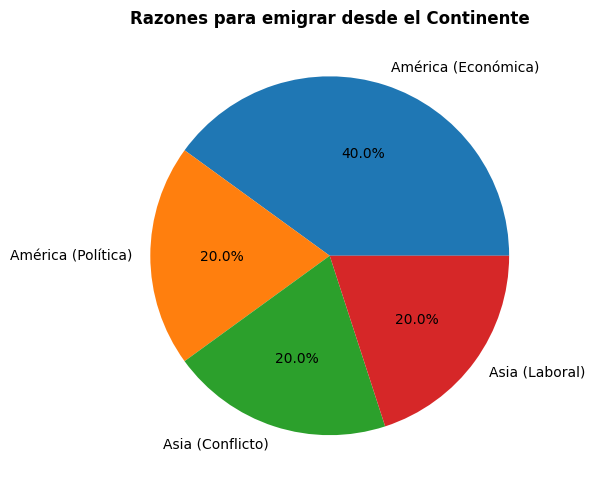

In [129]:
resultado_pandas = resultado.toPandas() # spark df a pandas

labels = resultado_pandas['Continente'] + ' (' + resultado_pandas['Razón'] + ')'

plt.figure(figsize=(6,6))
plt.pie(resultado_pandas['total_paises_origen'], labels=labels, autopct='%1.1f%%')
plt.title('Razones para emigrar desde el Continente', weight='bold')
plt.tight_layout()
plt.show()

##**4. Aplicación de MLlib para predicción de flujos migratorios (3 puntos)**
- Convierte los datos en un formato adecuado para MLlib.
- Aplica un modelo de regresión logística para predecir la probabilidad de migración basada  en factores socioeconómicos.
 Evalúa el modelo y analiza su precisión.

In [130]:
# regresión logística

# crear target (1: razón económica, 0: resto casos)
df1 =  df.withColumn("target",
                     when(col("Razón") == "Económica", 1)
                    .otherwise(0))

# no hay variables categóricas

# elegir atributos, solo variables numéricas
atributos = col_num.copy()
atributos.remove('Año')
print(f'Atributos para efectuar la regresión: {atributos}')

# transformar atributos a un solo vector columna y seleccionar esa columna junto con el target
assembler = VectorAssembler(inputCols=atributos, outputCol="atributos")
df_train = assembler.transform(df1).select("atributos", "target")

# train test split
train, test = df_train.randomSplit([0.64, 0.36], seed=42)

print(f'Vistazo al train set:')
train.show(truncate=False)

print(f'\nVistazo al test set:')
test.show(truncate=False)

# crear y entrenar modelo
lr = LogisticRegression(
    featuresCol="atributos",
    labelCol="target",
    standardization=True
)
modelo = lr.fit(train)

# predicciones para el train y test sets
pred_train = modelo.transform(train)
pred_test  = modelo.transform(test)

print("\nPredicción para el test set:")
pred_test.select("target", "prediction", "probability").show(truncate=False)

# evaluar modelo con accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="target", predictionCol="prediction", metricName="accuracy")
accuracy_train = evaluator.evaluate(pred_train)
accuracy_test = evaluator.evaluate(pred_test)

print(f"Accuracy para el train set: {accuracy_train:.2%}")
print(f"Accuracy para el test set : {accuracy_test:.2%}")

# analizar coeficientes del modelo
print("\nCoeficientes del modelo:")
import builtins # Import builtins to access the original abs
coeficientes = list(zip(atributos, modelo.coefficients))
for var, coef in sorted(coeficientes, key=lambda x: builtins.abs(x[1]), reverse=True):
    print(f"   - {var}: {coef:.4f}")

Atributos para efectuar la regresión: ['PIB_Origen', 'PIB_Destino', 'Tasa_Desempleo_Origen', 'Tasa_Desempleo_Destino', 'Nivel_Educativo_Origen', 'Nivel_Educativo_Destino', 'Población_Origen', 'Población_Destino']
Vistazo al train set:
+--------------------------------------------------+------+
|atributos                                         |target|
+--------------------------------------------------+------+
|[2200.0,43000.0,7.2,1.8,7.8,13.0,1.38E9,9800000.0]|0     |
|[2500.0,45000.0,15.4,4.5,6.2,14.1,1.8E7,8.3E7]    |0     |
|[8900.0,62000.0,5.2,3.8,8.5,12.3,1.25E8,3.31E8]   |1     |
+--------------------------------------------------+------+


Vistazo al test set:
+------------------------------------------------+------+
|atributos                                       |target|
+------------------------------------------------+------+
|[6000.0,15000.0,14.8,10.1,9.3,11.0,2.8E7,5.0E7] |0     |
|[10000.0,34000.0,9.5,13.2,11.5,13.8,4.5E7,4.7E7]|1     |
+-------------------------------

Los coeficientes del modelo están demasiado altos, por lo que hay sospecha de sobreajuste y no se espera que generalice bien a nuevos datos, a pesar de que acá se obtuvo el mismo accuracy para train y test sets.

Solo 4 variables tienen incidencia en el resultado:
- Nivel_Educativo_Destino: -3.7096
- Nivel_Educativo_Origen:   2.5695
- Tasa_Desempleo_Destino:   1.3654
- Tasa_Desempleo_Origen:   -0.4778

El aporte del resto de las variables es despreciable.

Por otra parte, hay pocos datos de entrenamiento y multicolinealidad:
- PIB_Origen y Nivel_Educativo_Origen: Correlación of 0.81
- Tasa_Desempleo_Destino y Nivel_Educativo_Origen: Correlación of 0.82
- PIB_Destino y Población_Destino: Correlación of 0.71

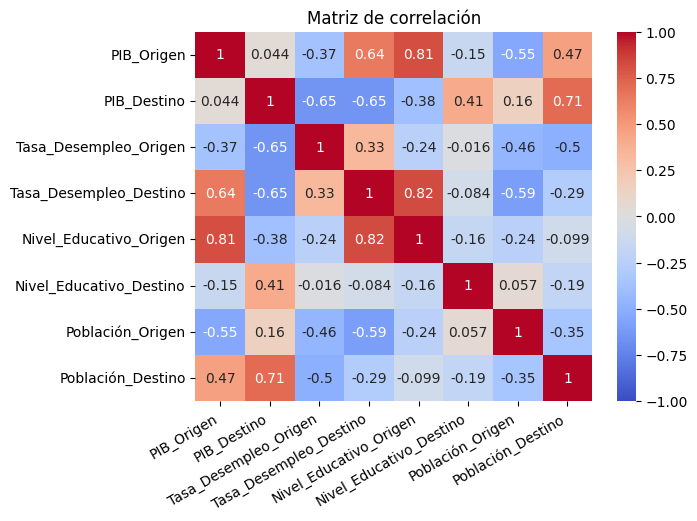

In [131]:
# matriz de correlación

corr = Correlation.corr(df_train, "atributos").head()[0]

# convertir matriz de corr a pd dataframe
corr_pandas = pd.DataFrame(corr.toArray(), columns=atributos, index=atributos)

sns.heatmap(corr_pandas, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Matriz de correlación", weight=True)
plt.xticks(rotation=30, ha='right')
plt.show()

Aplicamos más regularización elasticnet

In [132]:
# crear y entrenar modelo
lr = LogisticRegression(
    featuresCol="atributos",
    labelCol="target",
    standardization=True,
    elasticNetParam=0.33,
    regParam=0.01
)
modelo = lr.fit(train)

# predicciones para el train y test sets
pred_train = modelo.transform(train)
pred_test  = modelo.transform(test)

print("\nPredicción para el test set:")
pred_test.select("target", "prediction", "probability").show(truncate=False)

# evaluar modelo con accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="target", predictionCol="prediction", metricName="accuracy")
accuracy_train = evaluator.evaluate(pred_train)
accuracy_test = evaluator.evaluate(pred_test)

print(f"Accuracy para el train set: {accuracy_train:.2%}")
print(f"Accuracy para el test set : {accuracy_test:.2%}")

# analizar coeficientes del modelo
print("\nCoeficientes del modelo:")
import builtins # Import builtins to access the original abs
coeficientes = list(zip(atributos, modelo.coefficients))
for var, coef in sorted(coeficientes, key=lambda x: builtins.abs(x[1]), reverse=True):
    print(f"   - {var}: {coef:.4f}")


Predicción para el test set:
+------+----------+-----------------------------------------+
|target|prediction|probability                              |
+------+----------+-----------------------------------------+
|0     |0.0       |[0.9449880033600488,0.055011996639951155]|
|1     |1.0       |[0.4558832653603577,0.5441167346396423]  |
+------+----------+-----------------------------------------+

Accuracy para el train set: 100.00%
Accuracy para el test set : 100.00%

Coeficientes del modelo:
   - Nivel_Educativo_Destino: -0.7708
   - Nivel_Educativo_Origen: 0.4954
   - Tasa_Desempleo_Destino: 0.1051
   - Tasa_Desempleo_Origen: -0.0796
   - PIB_Origen: 0.0003
   - PIB_Destino: 0.0001
   - Población_Destino: 0.0000
   - Población_Origen: -0.0000


Accuracy en train y test set sigue siendo 100%.

Los coeficientes son más pequeños por efecto de la regularización, lo cual reduce la posibilidad de sobreajuste y permite, en teoría, una mejor generalización a nuevos datos. Se mantienen las mismas variables influyentes que en el modelo anterior, en el mismo orden y con coeficientes más pequeños.

La interpretación de estos nuevos coeficientes no es tan intuitiva:
- comportamiento lógico: A **mayor** educación en el país de origen → **mayor** probabilidad de migración por causa económica.
- comportamiento no intuitivo: A **mayor** educación en el país de destino → **menor** probabilidad de migración por causa económica.

Para concluir, a pesar de todo lo hecho, no se espera que el modelo generalice bien dado los pocos ejemplos de entrenamiento.

###**Cierre de la sesión**

In [133]:
# Detener y eliminar la sesión

import gc

if 'sesion_spark' in locals():
    # hay sesión activa ?
    if SparkSession.getActiveSession() is not None:
        sesion_spark.stop() # detener la sesión
        del sesion_spark # borrar la sesión
        gc.collect()
        print("✅ SparkSession eliminada exitosamente")
else:
    print("No existe sesion activa o inactiva")

✅ SparkSession eliminada exitosamente
